# Statistical testing benchmarks
> We have HoroRF benchmarks. Now let's see what we get:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from scipy.stats import ttest_ind

# Paired t-test
from scipy.stats import ttest_rel

In [121]:
# BENCHMARK_PATH = "HoroRF/logs/big_bench/hororf_results.tsv"
BENCHMARK_PATH = "data/processed/hororf_benchmarks/md3_dt_results.tsv"
# BENCHMARK_PATH = "data/processed/hororf_benchmarks/md3_n1_results.tsv"
# BENCHMARK_PATH = "data/processed/hororf_benchmarks/md3_n12_results.tsv"
# BENCHMARK_PATH = "data/processed/hororf_benchmarks/md6_n24_results.tsv"

ADD_PM = False

In [105]:
# Group by (n_samples, dataset, dim) and t-test classifier performances across 5 folds


def ttest_table(path):
    benchmarks = pd.read_table(path, index_col=0)  # Slightly updated (no resampling)
    grouped = benchmarks.groupby(["dataset", "dim", "n_samples"])
    ttest_results = []
    stats = []
    order_names = ["rf", "hrf", "hororf"]
    for (dataset, dim, n_samples), group in grouped:
        rf = group.loc[group["clf"] == "rf", "f1_micro"]
        hrf = group.loc[group["clf"] == "hrf", "f1_micro"]
        horo = group.loc[group["clf"] == "hororf", "f1_micro"]

        # t-tests
        rf_vs_hrf = ttest_rel(rf, hrf)
        rf_vs_hrf_sig = "*" if rf_vs_hrf.pvalue < 0.05 else ""
        rf_vs_horo = ttest_rel(rf, horo)
        rf_vs_horo_sig = "*" if rf_vs_horo.pvalue < 0.05 else ""
        hrf_vs_horo = ttest_rel(hrf, horo)
        hrf_vs_horo_sig = "*" if hrf_vs_horo.pvalue < 0.05 else ""

        # What's the order of performance?
        means = [rf.mean(), hrf.mean(), horo.mean()]
        order = np.argsort(means)
        # order_str = " > ".join([order_names[i] for i in order[::-1]])  # Reverse because argsort is ascending
        order_str = order_names[order[-1]]
        for i in order[-2::-1]:
            if means[i] == means[order[-1]]:
                marker = "="
            else:
                marker = ">"
            order_str += f" {marker} {order_names[i]}"
        # best = order_names[order[-1]]
        best = order_str.split(" > ")[0]
        if best.find("=") > -1:
            best = "{" + ", ".join(best.split(" = ")) + "}"

        # Aggregate results
        ttest_results.append(
            {
                "dataset": dataset,
                "dim": dim,
                "n_samples": n_samples if dataset != "polblogs_hypll" else 979,
                "n_scores": len(rf),
                "order": order_str,
                "best": best,
                "rf": rf.mean() * 100,
                "rf_std": rf.std() * 100,
                "hrf": hrf.mean() * 100,
                "hrf_std": hrf.std() * 100,
                "hororf": horo.mean() * 100,
                "hororf_std": horo.std() * 100,
                "rf_vs_hrf": rf_vs_hrf.pvalue,
                "sig1": rf_vs_hrf_sig,
                "rf_vs_horo": rf_vs_horo.pvalue,
                "sig2": rf_vs_horo_sig,
                "hrf_vs_horo": hrf_vs_horo.pvalue,
                "sig3": hrf_vs_horo_sig,
            }
        )

    ttest_results = pd.DataFrame(ttest_results)
    ttest_results = ttest_results.set_index(["dataset", "dim", "n_samples"])

    return ttest_results


ttest_results = ttest_table(BENCHMARK_PATH)
ttest_results

n_scores              order       best  \
dataset        dim n_samples                                           
gaussian       2   100              25  hrf > rf > hororf        hrf   
                   200              25  rf > hrf > hororf         rf   
                   400              25  hrf > rf > hororf        hrf   
                   800              25  hrf > rf > hororf        hrf   
               4   100              25  hrf > rf > hororf        hrf   
                   200              25  hrf > rf > hororf        hrf   
                   400              25  hrf > rf > hororf        hrf   
                   800              25  hrf > rf > hororf        hrf   
               8   100              25  hrf > rf > hororf        hrf   
                   200              25  hrf > rf > hororf        hrf   
                   400              25  hrf > rf > hororf        hrf   
                   800              25  hrf > rf > hororf        hrf   
               16  100              25  hrf = rf > hororf  {hrf, rf}   
                   200              25  rf > hrf > hororf         rf   
                   400              25  hrf = rf > hororf  {hrf, rf}   
                   800              25  hrf = rf > hororf  {hrf, rf}   
neuroseed      2   100              25  hrf > rf > hororf        hrf   
                   200              25  hrf > rf > hororf        hrf   
                   400              25  hrf > rf > hororf        hrf   
                   800              25  rf > hrf > hororf         rf   
               4   100              25  hrf > rf > hororf        hrf   
                   200              25  rf > hrf > hororf         rf   
                   400              25  hrf = rf > hororf  {hrf, rf}   
                   800              25  hrf = rf > hororf  {hrf, rf}   
               8   100              25  rf > hrf > hororf         rf   
                   200              25  hrf > rf > hororf        hrf   
                   400              25  rf > hrf > hororf         rf   
                   800              25  hrf > rf > hororf        hrf   
               16  100              25  hrf > rf > hororf        hrf   
                   200              25  hrf > rf > hororf        hrf   
                   400              25  hrf = rf > hororf  {hrf, rf}   
                   800              25  rf > hrf > hororf         rf   
polblogs_hypll 2   979              25  hrf > rf > hororf        hrf   
               4   979              25  hrf > rf > hororf        hrf   
               8   979              25  rf > hrf > hororf         rf   
               16  979              25  hrf > rf > hororf        hrf   

                                      rf     rf_std         hrf    hrf_std  \
dataset        dim n_samples                                                 
gaussian       2   100         86.600000  13.127579   87.400000  15.419144   
                   200         89.700000   9.691061   89.000000  10.557383   
                   400         88.750000   9.702609   90.450000   9.325424   
                   800         89.800000   9.002531   91.325000   9.486009   
               4   100         99.000000   2.500000   99.600000   1.384437   
                   200         99.400000   1.307032   99.700000   0.829156   
                   400         99.150000   1.286954   99.700000   0.653516   
                   800         99.650000   0.600564   99.825000   0.338502   
               8   100         99.200000   2.362908   99.600000   1.384437   
                   200         99.400000   1.493039   99.600000   1.181454   
                   400         99.750000   0.721688   99.850000   0.414578   
                   800         99.900000   0.390312  100.000000   0.000000   
               16  100         99.800000   1.000000   99.800000   1.000000   
                   200        100.000000   0.000000   99.900000   0.500000   
                   400        100.000000   0.

In [106]:
# Win/tie counts:
def tally_wins(df):
    wins = {"rf": 0, "hrf": 0, "hororf": 0}
    for name, count in df.groupby("order").count()["n_scores"].items():
        name = name.split(" > ")[0]
        for clf in name.split(" = "):
            wins[clf] += count
    return wins


wins = tally_wins(ttest_results)
wins

{'rf': 14, 'hrf': 28, 'hororf': 0}

In [103]:
# Publish as LaTeX table


# Get output path
def latexify(table, add_pm=True):
    sig_lookup1 = {"rf": ["sig1", "sig2"], "hrf": ["sig1", "sig3"], "hororf": ["sig2", "sig3"]}
    sig_lookup2 = {
        ("rf", "sig1"): "*",  # RF beats HRF
        ("rf", "sig2"): "$\dagger$",  # RF beats HoroRF
        ("hrf", "sig1"): "$\ddagger$",  # HRF beats RF
        ("hrf", "sig3"): "$\dagger$",  # HRF beats HoroRF
        ("hororf", "sig2"): "$\ddagger$",  # HoroRF beats RF
        ("hororf", "sig3"): "*",  # HoroRF beats HRF
    }

    # Make everything plus/minus std (or just convert to float)
    table["rf"] = table["rf"].map("{:.2f}".format)
    table["hrf"] = table["hrf"].map("{:.2f}".format)
    table["hororf"] = table["hororf"].map("{:.2f}".format)

    if add_pm:
        table["rf"] += "$\pm$" + table["rf_std"].map("{:.2f}".format)
        table["hrf"] += "$\pm$" + table["hrf_std"].map("{:.2f}".format)
        table["hororf"] += "$\pm$" + table["hororf_std"].map("{:.2f}".format)

    # Add significance markers, bold best score
    for idx, row in table.iterrows():
        best_ids = row["best"].lstrip("{").rstrip("}").split(", ")
        for best_id in best_ids:
            text = f"\\textbf{{{row[best_id]}}}"
            for sig in sig_lookup1[best_id]:
                if row[sig] == "*":
                    text += "\\textsuperscript{" + sig_lookup2[(best_id, sig)] + "}"
            table.loc[idx, best_id] = text

    # Rename datasets cleanly
    table = table.rename(index={"gaussian": "Gaussian", "neuroseed": "NeuroSEED", "polblogs_hypll": "Polblogs"})

    # ttest_latex = ttest_latex.drop(columns=["n_scores", "order", "sig1", "sig2", "sig3", "rf_vs_hrf", "rf_vs_horo", "hrf_vs_horo"])
    table = table[["hrf", "rf", "hororf"]]
    table.columns = ["fastH", "sklearn", "HoroRF"]
    table = table.rename_axis(["Data", "$d$", "$n$"])

    return table


ttest_latex = latexify(ttest_results, add_pm=ADD_PM)
outpath = BENCHMARK_PATH.replace(".tsv", ".tex")
ttest_latex.to_latex(outpath, escape=False, sparsify=True, float_format="%.2f")

In [123]:
# Joint dt + rf
dt_path = "data/processed/hororf_benchmarks/md3_dt_results.tsv"
rf_path = "data/processed/hororf_benchmarks/md3_n12_results.tsv"
dt_table = latexify(ttest_table(dt_path), add_pm=ADD_PM)
rf_table = latexify(ttest_table(rf_path), add_pm=ADD_PM)
merged = pd.merge(dt_table, rf_table, left_index=True, right_index=True, suffixes=("_dt", "_rf"))
merged.columns = ["fastH", "Sklearn", "Horo", "fastH", "Sklearn", "Horo"]

# Make a multiindex for the columns: (Decision Trees, Random Forests) x (fastH, Sklearn, Horo):
merged.columns = pd.MultiIndex.from_product([["Decision Trees", "Random Forests"], ["fastH", "Sklearn", "Horo"]])
merged.to_latex("data/processed/hororf_benchmarks/merged.tex", escape=False, sparsify=True, float_format="%.2f")

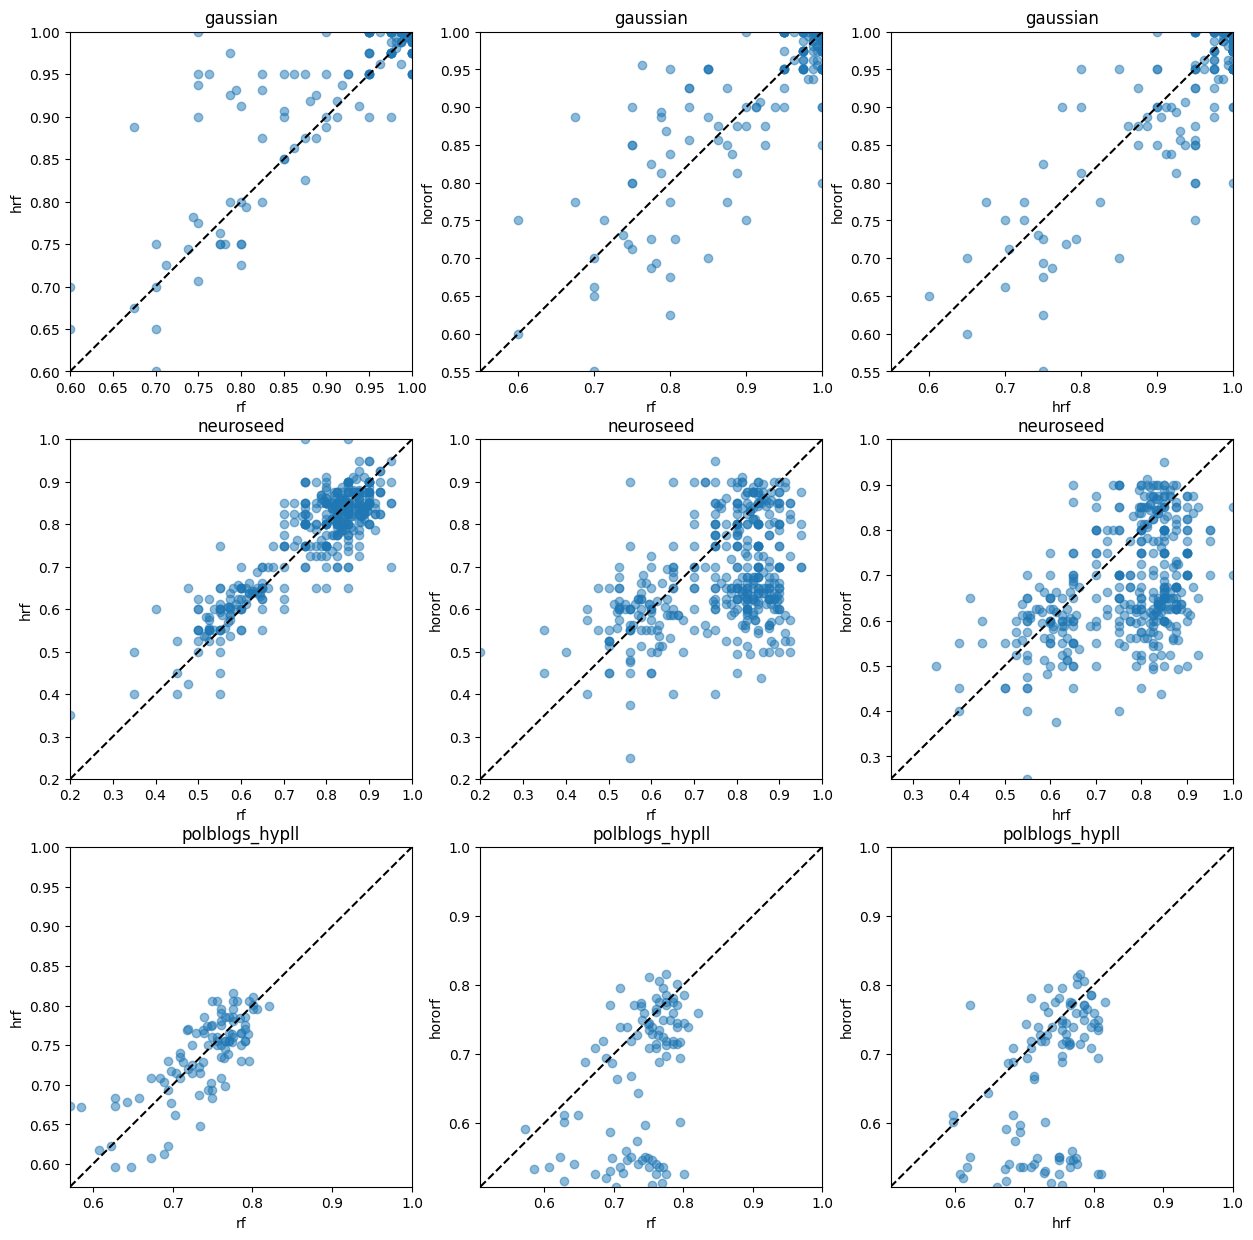

In [84]:
# Scatterplots

datasets = benchmarks["dataset"].unique()
clfs = ["rf", "hrf", "hororf"]
clf_pairs = [("rf", "hrf"), ("rf", "hororf"), ("hrf", "hororf")]
n_datasets = len(datasets)
fig, axs = plt.subplots(3, n_datasets, figsize=(5 * n_datasets, 15))

for i, dataset in enumerate(datasets):
    for j, (clf1, clf2) in enumerate(clf_pairs):
        to_plot = benchmarks.loc[benchmarks["dataset"] == dataset]
        to_plot1 = to_plot.loc[to_plot["clf"] == clf1, "f1_micro"]
        to_plot2 = to_plot.loc[to_plot["clf"] == clf2, "f1_micro"]
        axs[i, j].scatter(to_plot1, to_plot2, alpha=0.5)
        axs[i, j].set_xlabel(clf1)
        axs[i, j].set_ylabel(clf2)
        axs[i, j].set_title(dataset)
        min_all = min(min(to_plot1), min(to_plot2))
        axs[i, j].plot([min_all, 1], [min_all, 1], label="y=x", color="black", linestyle="dashed")
        axs[i, j].set_xlim([min_all, 1])
        axs[i, j].set_ylim([min_all, 1])

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


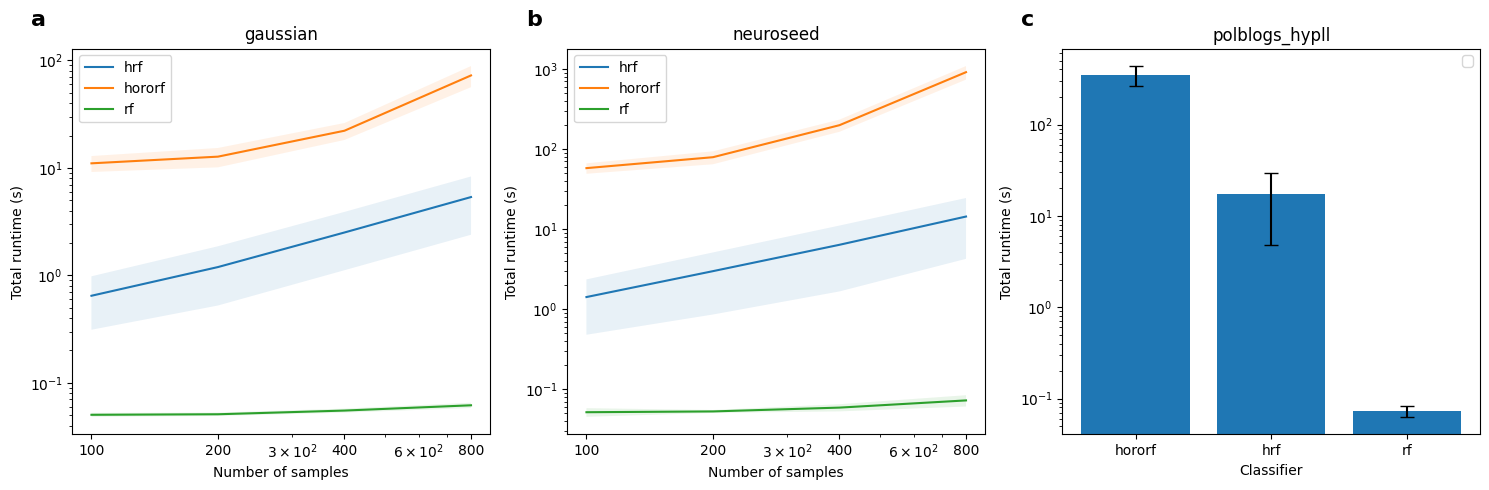

In [99]:
# Times

# times = pd.read_table("HoroRF/logs/big_bench/hororf_times.tsv", index_col=0)
times = pd.read_table("data/processed/hororf_benchmarks/md3_n12_times.tsv", index_col=0)

datasets = times["dataset"].unique()
clfs = times["clf"].unique()

fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5))

for dataset, ax in zip(datasets, axs):
    data_filtered = times[times["dataset"] == dataset]
    if len(data_filtered["n_samples"].unique()) > 1:
        for clf in clfs:
            to_plot = data_filtered[data_filtered["clf"] == clf]
            means = to_plot.groupby("n_samples")["time"].mean()
            stds = to_plot.groupby("n_samples")["time"].std()
            ci_upper = means + stds
            ci_lower = means - stds
            ax.plot(means.index, means, label=clf)
            ax.fill_between(means.index, ci_lower, ci_upper, alpha=0.1)
            ax.set_xscale("log")
            ax.set_xticks([100, 200, 400, 800], ["100", "200", "400", "800"])
        ax.set_xlabel("Number of samples")

    else:
        to_plot = data_filtered.groupby("clf")["time"]
        ax.bar(to_plot.groups.keys(), to_plot.mean(), yerr=to_plot.std(), capsize=5)
        ax.set_xlabel("Classifier")

    # Add labels
    ax.set_title(dataset)
    ax.set_ylabel("Total runtime (s)")
    ax.set_yscale("log")
    ax.legend()

    # Label subfigures
    ax.text(
        -0.1,
        1.1,
        chr(ord("a") + list(datasets).index(dataset)),
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
    )

fig.tight_layout()